In [87]:
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, Tensor
from torch.utils.data import Dataset, DataLoader

In [2]:
def f(abscissa):
    return 2 * abscissa ** 2 + abscissa + 1

In [3]:
NUM_EXAMPLES = 1000

In [86]:
data_x: np.ndarray = np.linspace(-2, 2, NUM_EXAMPLES)
noise: np.ndarray = np.random.randn(NUM_EXAMPLES)
data_y_true: np.ndarray = f(data_x)
data_y: np.ndarray = data_y_true + noise

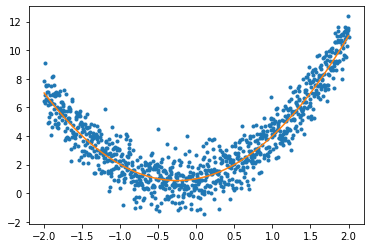

In [30]:
plt.plot(data_x, data_y, '.', label='Data')
plt.plot(data_x, data_y_true, label='Ground truth')
plt.show()

In [88]:
class NPDataset(Dataset):
    __features: Tensor
    __labels: Tensor

    def __init__(self, features: np.ndarray, labels: np.ndarray):
        self.__features = torch.from_numpy(features).float()
        self.__labels = torch.from_numpy(labels).float()

    def __len__(self):
        return len(self.__labels)

    def __getitem__(self, idx: int) -> tuple[torch.Tensor, torch.Tensor]:
        return self.__features[idx], self.__labels[idx]


data_x_reshaped: np.ndarray = data_x.reshape((-1, 1))
data_y_reshaped: np.ndarray = data_y.reshape((-1, 1))
dataset = NPDataset(data_x_reshaped, data_y_reshaped)
data_loader = DataLoader(dataset, batch_size=NUM_EXAMPLES, shuffle=False)

In [124]:
class CustomLinear(torch.nn.Module):
    __weights: nn.Parameter
    __bias: nn.Parameter

    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.__weights = nn.Parameter(torch.empty(in_features, out_features))
        nn.init.xavier_uniform_(self.__weights)
        self.__bias = nn.Parameter(torch.zeros(out_features))

    def forward(self, x: Tensor) -> Tensor:
        return x @ self.__weights + self.__bias

In [125]:
model_sequential = nn.Sequential(
        CustomLinear(1, 32),
        nn.ReLU(),
        CustomLinear(32, 32),
        nn.ReLU(),
        CustomLinear(32, 16),
        nn.ReLU(),
        CustomLinear(16, 16),
        nn.ReLU(),
        CustomLinear(16, 8),
        nn.ReLU(),
        CustomLinear(8, 8),
        nn.ReLU(),
        CustomLinear(8, 4),
        CustomLinear(4, 2),
        CustomLinear(2, 1),
)

In [126]:
learning_rate = 0.01
batch_size = NUM_EXAMPLES
epochs = 500

In [127]:
mse = nn.MSELoss()
sgd = torch.optim.SGD(model_sequential.parameters(), lr=learning_rate)
mae = torch.nn.L1Loss()

In [128]:
def train_loop(dataloader: DataLoader, model: torch.nn.Module, loss_fn: Callable[[Tensor, Tensor], Tensor],
               optimizer: torch.optim.Optimizer):
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred: Tensor = model(X)
        loss: Tensor = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return loss.item()


def test_loop(dataloader, model, loss_fn, metric) -> tuple[float, float]:
    num_batches: int = len(dataloader)
    test_loss: float = 0.0
    test_metric: float = 0.0

    with torch.no_grad():
        for X, y in dataloader:
            pred: Tensor = model(X)
            test_loss += loss_fn(pred, y).item()
            test_metric += metric(pred, y).item()

    test_loss /= num_batches
    test_metric /= num_batches

    return test_loss, test_metric

In [129]:
for t in range(epochs):
    print(f"Epoch {t + 1}/{epochs}\n-------------------------------")
    train_mse_loss: float = train_loop(data_loader, model_sequential, mse, sgd)
    test_mse_loss, test_mae_metric = test_loop(data_loader, model_sequential, mse, mae)
    print(f'Train mse: {train_mse_loss:.4f}, Test mse: {test_mse_loss:.4f}, Test mae: {test_mae_metric:.4f}')
print("Done!")

Epoch 1/500
-------------------------------
Train mse: 21.3134, Test mse: 19.9529, Test mae: 3.5417
Epoch 2/500
-------------------------------
Train mse: 19.9529, Test mse: 18.8039, Test mae: 3.3939
Epoch 3/500
-------------------------------
Train mse: 18.8039, Test mse: 17.7366, Test mae: 3.2562
Epoch 4/500
-------------------------------
Train mse: 17.7366, Test mse: 16.7252, Test mae: 3.1261
Epoch 5/500
-------------------------------
Train mse: 16.7252, Test mse: 15.7531, Test mae: 3.0018
Epoch 6/500
-------------------------------
Train mse: 15.7531, Test mse: 14.8088, Test mae: 2.8825
Epoch 7/500
-------------------------------
Train mse: 14.8088, Test mse: 13.8898, Test mae: 2.7695
Epoch 8/500
-------------------------------
Train mse: 13.8898, Test mse: 13.0037, Test mae: 2.6638
Epoch 9/500
-------------------------------
Train mse: 13.0037, Test mse: 12.1598, Test mae: 2.5679
Epoch 10/500
-------------------------------
Train mse: 12.1598, Test mse: 11.3685, Test mae: 2.4819

In [130]:
with torch.no_grad():
    predictions: torch.Tensor = model_sequential(torch.tensor(data_x_reshaped).float())

In [131]:
predictions_numpy: np.ndarray = predictions.numpy().reshape((-1))

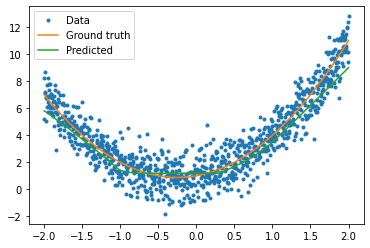

In [132]:
plt.plot(data_x, data_y, '.', label='Data')
plt.plot(data_x, data_y_true, label='Ground truth')
plt.plot(data_x, predictions_numpy, label='Predicted')
plt.legend()
plt.show()